# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [163]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [164]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.common import get_name_15min_chart, get_name_15min_chart_now

## yfinance による株価データの取得

In [165]:
code = "N225"
symbol = f"^{code}"
ticker = yf.Ticker(symbol)
df = ticker.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-09-09 09:00:00+09:00,43907.550781,44074.351562,43834.671875,44051.929688,0,0.0,0.0
2025-09-09 09:15:00+09:00,44069.871094,44069.871094,43961.589844,44040.191406,0,0.0,0.0
2025-09-09 09:30:00+09:00,44044.070312,44095.628906,44009.531250,44091.988281,0,0.0,0.0
2025-09-09 09:45:00+09:00,44089.980469,44185.730469,44085.000000,44127.371094,0,0.0,0.0
2025-09-09 10:00:00+09:00,44123.390625,44123.390625,44010.488281,44010.488281,0,0.0,0.0
2025-09-09 10:15:00+09:00,43996.960938,44011.191406,43886.011719,43912.609375,0,0.0,0.0
2025-09-09 10:30:00+09:00,43914.820312,43932.898438,43762.871094,43818.558594,0,0.0,0.0
2025-09-09 10:45:00+09:00,43815.308594,43826.531250,43725.289062,43753.968750,0,0.0,0.0
2025-09-09 11:00:00+09:00,43753.031250,43806.011719,43753.031250,43767.531250,0,0.0,0.0


## 前日終値の取得

In [166]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-09-02 00:00:00+09:00    42310.488281
2025-09-03 00:00:00+09:00    41938.890625
2025-09-04 00:00:00+09:00    42580.269531
2025-09-05 00:00:00+09:00    43018.750000
2025-09-08 00:00:00+09:00    43643.808594
2025-09-09 00:00:00+09:00    43588.738281
Name: Close, dtype: float64


Date
2025-09-08 00:00:00+09:00    43643.808594
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [167]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

+263.74


## ローソク足チャート（小さいサイズ）

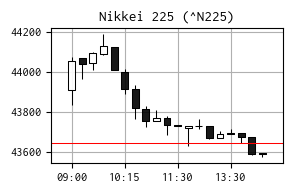

In [168]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 9

fig, ax = plt.subplots(figsize=(3, 2))
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.axhline(y=lastclose, color="red", linewidth=0.75)
ax.set_ylabel(None)
ax.grid()

if "shortName" in ticker.info:
    ax.set_title(f"{ticker.info['shortName']} ({symbol})")
elif "longName" in ticker.info:
    ax.set_title(f"{ticker.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()